In [1]:
from __future__ import annotations
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab
from astropy.io import fits
import pandas as pd
from dataclasses import dataclass

from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
@dataclass
class Spec:
    freq: np.ndarray
    data: np.ndarray
    vel: np.ndarray
    params: dict
    possible_relative_velocities: np.ndarray | None = None

In [3]:
def load(dataset: str):
    hdulist = fits.open(dataset)
    hdr = hdulist[0].header
    params = {}

    # spec.fileName = fname;
    # spec.data = fitsread(fname);
    # spec.info = fitsinfo(fname);
    
    # % get the frequency scale from the spec.header of the fits files
    # freq_ref_pix = getKeyword(spec, 'CRPIX1') + 2;
    # freq_delta = getKeyword(spec, 'CDELT1');
    # %disp(2*freq_delta)
    # freq_ref = getKeyword(spec, 'CRVAL1');
    # n_chan = getKeyword(spec, 'NAXIS1');
    # vlsr = getKeyword(spec, 'VELO-LSR')*1000;
            
    # spec.freq = freq_ref + ( (1:n_chan) - freq_ref_pix )*freq_delta;
    # spec.vel = (  -(spec.freq - freq_ref)/freq_ref * ...
    #     spec.c - vlsr) / 1000; % Changed VLSR sign 2015-06-23 to work with SalsaJ
    # spec.index = 1:n_chan;
    # spec.baseSubtracted = 0;
    # spec.gaussiansFitted = 0;

    freq_ref_pix = hdr['CRPIX1'] + 2
    freq_delta = hdr['CDELT1']
    freq_ref = hdr['CRVAL1']
    n_chan = hdr['NAXIS1']
    params['frequency'] = freq_ref

    params['l'] = ufloat(hdr['CRVAL2'], 1.5)
    params['b'] = hdr['CRVAL3']

    vlsr = hdr['VELO-LSR'] * 1000  # m/s
    params['dt'] = hdr['OBSTIME']

    freq = np.array(freq_ref + (np.arange(1, n_chan+1) - freq_ref_pix) * freq_delta)
    
    bzero = hdr['BZERO']
    bscale = hdr['BSCALE']
    d = hdulist[0].data[0,0,:] * bscale + bzero
    data = to_dB(np.array(d))

    # This is the method we derived
    # vel = -((freq - H21) / freq * sc.constants.c - vlsr) / 1000  # km/s
    
    # This is what Salsa uses
    vel = -((freq - H21) / H21 * sc.constants.c - vlsr) / 1000  # km/s

    spec = Spec(freq, data, vel, params)

    return spec  # :)

In [4]:
data: list[Spec] = []

files = glob("../data/salsa/spectrum_?????.fits")
files.sort()

for file in files:
    spec = load(file)
    data.append(spec)

## Fitting gaussians

In [5]:
def gaussian(x, amplitude, mu, sigma):
    return amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gaussians(x, offset, *params):
    return offset + sum(gaussian(x, *params[i:i+3]) for i in range(0, len(params), 3))

In [6]:
def do_fits(spectrum, number: int = 3, guesses: list[float] = None):
    if guesses is None:
        mini, maxi = np.min(spec.vel), np.max(spec.vel)
        guesses = np.linspace(mini, maxi, number, endpoint=True)
        lower_bound = [0] + [0, mini, 0.00001] * number
        upper_bound = [100] + [1, maxi, 100] * number
    else:
        assert len(guesses) == number
        lower_bound = [0] + [x for xs in ((0, g - 40, 0.00001) for g in guesses) for x in xs]
        upper_bound = [100] + [x for xs in ((1, g + 40, 100) for g in guesses) for x in xs]

    p0 = [0] + [x for xs in ((0.0001, g, 10) for g in guesses) for x in xs]

    popt, pcov = sc.optimize.curve_fit(
        gaussians,
        spectrum.vel, spectrum.data,
        p0 = p0,
        bounds = (lower_bound, upper_bound),
        check_finite = False
    )
    return popt, pcov

In [7]:
all_params = [
    (3, [-110, -70, -20]),          # 0
    (3, [-110, -70, -20]),          # 1
    (3, [-110, -70, -20]),          # 2
    (3, [-110, -70, -20]),          # 3
    (3, [-100, -50, 10]),           # 4
    (3, [-90, -60, 20]),            # 5
    (3, [-60, -30, 20]),            # 6
    (2, [-20, 40]),                 # 7
    (3, [-40, 0, 60]),              # 8
    (2, [10, 60]),                  # 9
    (2, [0, 70]),                   # 10
    (2, [30, 50]),                  # 11
    (1, [50]),                      # 12
    (1, [50]),                      # 13
    (1, [60]),                      # 14
    (3, [-110, -80, -40]),          # 15
    (3, [-120, -80, -40]),          # 16
    (3, [-130, -80, -50]),          # 17
    (2, [-130, -50]),               # 18
    (3, [-130, -70, -40]),          # 19
    (3, [-130, -70, -40]),          # 20
    (3, [-130, -70, -30]),          # 21
    (3, [-130, -70, -20]),          # 22
    (3, [-130, -60, -20]),          # 23
    (4, [-130, -90, -50, 0]),       # 24
    (4, [-130, -80, -50, 0]),       # 25
]
all_params += [(1, None)] * (len(data) - len(all_params))

show_plots = False
for j, (spec, (n, guesses)) in enumerate(zip(data, all_params)):
    popt, pcov = do_fits(spec, n, guesses)
    spec.possible_relative_velocities = unp.uarray(popt[2::3], np.sqrt(np.diag(pcov))[3::3]) * 1000  # m/s

    if show_plots:
        plt.plot(spec.vel, spec.data)
        ylims = plt.ylim()
        plt.plot(spec.vel, gaussians(spec.vel, *popt))
        for i in range(1, len(popt), 3):
            plt.plot(spec.vel, popt[0] + gaussian(spec.vel, *popt[i:i+3]), ls=':', color='C1')
        plt.ylim(ylims)
        plt.title(f"{j=}, l = {spec.params["l"]:.1f}")
        plt.show()

## Calculating distance

In [8]:
def oort_distance_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A.n / unp.sin(2 * galactic_rad)
    return abs(d)

In [9]:
def tangent_method(relative_velocity: float, galactic_longitude: float) -> tuple[float, float]:
    galactic_rad = deg2rad(galactic_longitude)
    V_hydrogen = relative_velocity + V0 * unp.sin(galactic_rad)
    R = R0 * unp.sin(galactic_rad) * np.ones_like(relative_velocity)
    return V_hydrogen, R

In [10]:
def velocity_vector_method(relative_velocity: float, galactic_longitude: float) -> tuple[float, float]:
    galactic_rad = deg2rad(galactic_longitude)

    d = oort_distance_estimate(relative_velocity, galactic_longitude)
    # R = R0 - d * unp.cos(galactic_rad)
    R = (R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad)) ** 0.5

    V_hydrogen_cloud = R / R0 * (relative_velocity / unp.sin(galactic_rad) + V0)
    return V_hydrogen_cloud, R

In [11]:
def oort_method(relative_velocity: float, galactic_longitude: float) -> tuple[float, float]:
    galactic_rad = deg2rad(galactic_longitude)

    d = oort_distance_estimate(relative_velocity, galactic_longitude)
    R = (R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad)) ** (0.5)

    V_hydrogen_cloud = (
        (relative_velocity + V0 * unp.sin(galactic_rad)) ** 2
        + (d * (OORT_B + OORT_A * unp.cos(galactic_rad) - V0 * unp.cos(galactic_rad))) ** 2
    ) ** 0.5
    return V_hydrogen_cloud, R

In [61]:
velocities = [[], [], []]  # tangent, velocity, oort
rel_velocities = [[], [], []]  # tangent, velocity, oort
radii = [[], [], []]
longitudes = [[], [], []]


for spec in data:
    l = spec.params['l']
    if l < 90:
        max_relative_velocity_idx = np.argmax(np.abs(spec.possible_relative_velocities))
        max_rel_vel = spec.possible_relative_velocities[max_relative_velocity_idx]

        # Or second largest value:
        almost_max_rel_idx = np.argsort(np.abs(spec.possible_relative_velocities))
        almost_max_rel_vel = spec.possible_relative_velocities[almost_max_rel_idx[-2] if len(almost_max_rel_idx) > 1 else almost_max_rel_idx[0]]

        # Or peak value:
        top_rel_idx = np.argmax(spec.data)
        top_rel_vel = spec.vel[top_rel_idx] * 1000
        # plt.plot(spec.vel, spec.data)
        # plt.axvline(top_rel_vel)
        # plt.show()

        V, R = tangent_method(max_rel_vel, l)
        velocities[0].append(V / 1000)
        radii[0].append(R)
        longitudes[0].append(l)
        rel_velocities[0].append(max_rel_vel)

        # Yes this is sus, but there's no reason it should not work
        top_rel_vel_err = ufloat(top_rel_vel, 5e3)
        V, R = velocity_vector_method(top_rel_vel_err, l)
        velocities[1].append(V / 1000)
        radii[1].append(R)
        longitudes[1].append(l)
        rel_velocities[1].append(top_rel_vel_err)
        # for Vr in spec.possible_relative_velocities:
        #     V, R = velocity_vector_method(Vr, l)
        #     velocities[1].append(V / 1000)
        #     radii[1].append(R)
        #     longitudes[1].append(l)
        #     rel_velocities[1].append(Vr)
            # V, R = oort_method(Vr, l)
            # velocities[2].append(V / 1000)
            # radii[2].append(R)
            # longitudes[2].append(l)

    elif l < 130:
        for Vr in spec.possible_relative_velocities:
            V, R = velocity_vector_method(Vr, l)
            velocities[1].append(V / 1000)
            radii[1].append(R)
            longitudes[1].append(l)
            rel_velocities[1].append(Vr)

            V, R = oort_method(Vr, l)
            velocities[2].append(V / 1000)
            radii[2].append(R)
            longitudes[2].append(l)
            rel_velocities[2].append(Vr)

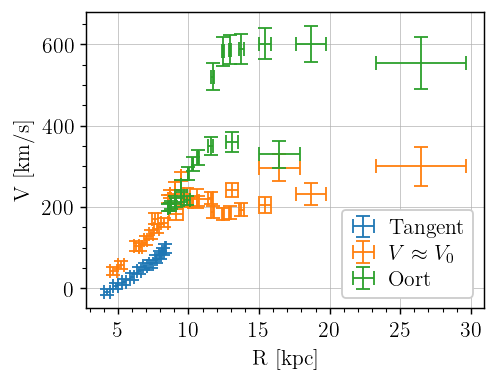

In [62]:
plt.errorbar(nom_vals(radii[0]), nom_vals(velocities[0]), yerr=std_devs(velocities[0]), xerr=std_devs(radii[0]), ls='none', label='Tangent')
plt.errorbar(nom_vals(radii[1]), nom_vals(velocities[1]), yerr=std_devs(velocities[1]), xerr=std_devs(radii[1]), ls='none', label=r'$V \approx V_0$')
plt.errorbar(nom_vals(radii[2]), nom_vals(velocities[2]), yerr=std_devs(velocities[2]), xerr=std_devs(radii[2]), ls='none', label='Oort')

# plt.scatter(nom_vals(sum(radii, start=[])), nom_vals(sum(velocities, start=[])), c=nom_vals(sum(longitudes, start=[])), marker='d', zorder=2)
# plt.scatter(nom_vals(radii[1]), nom_vals(velocities[1]), c=nom_vals(longitudes[1]), marker='d', zorder=2)
# plt.colorbar()

plt.xlabel("R [kpc]")
plt.ylabel("V [km/s]")

# plt.xlim(0, 8.5)
# plt.ylim(0, 400)
plt.legend()
plt.savefig("../figures/SALSA_velocity_curve.pdf")

## What are we looking at???

In [53]:
def calculate_distance(relative_velocity, radius, galactic_longitude, method) -> float:
    l = galactic_longitude
    lrad = deg2rad(l)

    if method == 'tan':
        return R0 * unp.cos(lrad) * np.ones_like(relative_velocity)
    if method == 'vel_2solutions':
        a = (radius**2 - R0**2 * unp.sin(lrad)**2) ** 0.5
        b = R0 * unp.cos(lrad)
        dplus = a + b
        dminus = b - a
        return [dplus, dminus]
    if method == 'vel_plus':
        a = (radius**2 - R0**2 * unp.sin(lrad)**2) ** 0.5
        b = R0 * unp.cos(lrad)
        dplus = a + b
        return dplus
    if method == 'oort':
        return oort_distance_estimate(relative_velocity, l)

    assert False, "Skill issue"

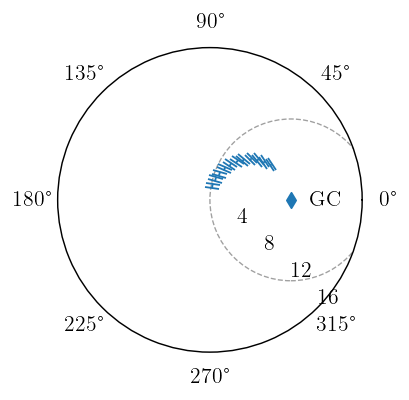

In [56]:
distances = []
angles = []
for Vrs, Rs, l in zip(rel_velocities[0], radii[0], longitudes[0]):
    ds = calculate_distance(Vrs, Rs, l, 'tan')
    distances.append(ds)
    angles.append(deg2rad(l))

for Vrs, Rs, l in zip(rel_velocities[1], radii[1], longitudes[1]):
    if l < 90:
        ds = calculate_distance(Vrs - l, Rs, l, 'tan')
        distances.extend([ds])
        angles.extend((deg2rad(l),) * len([ds]))
    else:
        ds = calculate_distance(Vrs, Rs, l, 'vel_plus')
        distances.append(ds)
        angles.extend((deg2rad(l),))

for Vrs, Rs, l in zip(rel_velocities[2], radii[2], longitudes[2]):
    ds = calculate_distance(Vrs, Rs, l, 'oort')
    distances.append(ds)
    angles.append(deg2rad(l))


with mpl.rc_context():
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM)
    mpl.rcParams["figure.subplot.left"]   = 0.05
    mpl.rcParams['figure.subplot.right']  = 0.99
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.12

    ax = plt.subplot(projection="polar")

    # plt.scatter(longitudes_array, nom_vals(bad_distances))
    plt.errorbar(nom_vals(angles), nom_vals(distances), yerr=std_devs(distances), ls='none')
    # plt.scatter(longitudes_array, less_bad_distances_minus)
    plt.scatter(0, R0, label="Center of galaxy", marker='d')
    plt.annotate('GC', (0, R0), (0, R0 + 2), backgroundcolor='white', verticalalignment='center')

    circle = plt.Circle((R0, 0), R0, transform=ax.transData._b, facecolor=None, fill=False, ls='--', color="#a0a0a0", zorder=0, lw=0.75)
    ax.add_patch(circle)

    plt.yticks([4,8,12, 16])
    ax.set_rlabel_position(315)
    plt.ylim(0, 16)  # outliers begone
    plt.grid(False)

    # plt.legend(loc='lower left')
    plt.savefig("../figures/SALSA_galaxy_map.pdf")